# Team 1: From black box to explanable AI: the trade-off between accuracy of complexity


In the project, we are exploring multiple machine learning methods spanning different ranges of explainability, complexity, and accuracy. Specifically, we will explore three types of machine learning models, which are neural networks (deterministic, black box), Gaussian process regression (probablistic, model data dependencies), and symbolic regression (output functions explicitly), and finally compare their performances on the accuracy-complexity axises.

# 0. Setup workspace and Import packages 

In [3]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point, performance_sigma_point_batched
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/ML_Project2_Team1


### PySR specific packages 

In [ ]:
# load PySR
!pip install -U pysr

In [ ]:
import pysr
import sympy
from pysr import PySRRegressor


## Data Preparation

In [5]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

In [6]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

In [7]:
mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)

started


In [8]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
valid_data = np.loadtxt(url, delimiter=None)[:,3:] 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [9]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 1. Neural Network

# 2. Gaussian Process

Gaussian Process (GP) can learn the probability distribution of the target function and make probabilistic predictions given new inputs. Compared with neural networks, GP inherently model the dependencies between different data points through a covariance function (kernel), and therefore the correlation between the shape function values at different positions can be modeled explicitly using the kernel function. **In this section, we aim to use Gaussian Process Regression (GPR) to predict the shape function values and examine whether accounting for data interdependencies could help increase the prediction accuracy. Following that, we will use SHAP (SHapley Additive exPlanations) analysis to identify the key features that contribute most to the model prediction.**  

In [10]:
import torch
import gpytorch
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import shap
import time

## 2.1 Gaussian Process Regression

GP has very high computational complexicity that is proportional to the cube of the sample size O(n^3), making the training process impossible with over 900k samples (the server would explode in one sec). Therefore, we switch to Stochatic Variational Gaussian Process (SVGP) as an approximation of exact GP, which introduces variational inference (approximating intractable posterior distributions) and inducing points (a smaller set of pseudo-inputs to represent the full dataset) to speed up the calculation.

In [11]:
# Define Approximate GP Model (SVGP)
class MultitaskSVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=500, input_dim=4, num_tasks=16):
        # Using variational inference method
        inducing_points = torch.randn(num_inducing, input_dim)
        
        batch_shape = torch.Size([num_tasks])
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks
        )
        
        super(MultitaskSVGPModel, self).__init__(variational_strategy)
        
        # Mean and kernel function
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Early stop when validation loss cease to decrease
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss, model, likelihood):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, likelihood)
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
    def save_checkpoint(self, model, likelihood):
        """Save the model checkpoint."""
        torch.save({
            'model_state_dict': model.state_dict(),
            'likelihood_state_dict': likelihood.state_dict()
        }, self.path)
        print(f'Model checkpoint saved to {self.path}')
        
    def load_checkpoint(self, model, likelihood):
        """Load the best model checkpoint."""
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])
        likelihood.load_state_dict(checkpoint['likelihood_state_dict'])
        return model, likelihood

### Data and model setup

In [12]:
# Load Training Data
X = x  # Shape: (917858, 4)
Y = y  # Shape: (917858, 16)

# Normalize inputs to improve GP performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X.cpu().numpy())

# Convert to Torch tensors
X_train = torch.tensor(X_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

# Data Batch Loader Function
def get_batch_loader(X, Y, batch_size=1024, shuffle=True):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Prepare validation data
valid_x_scaled = scaler_X.transform(valid_x.cpu().numpy())
valid_x_tensor = torch.tensor(valid_x_scaled, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)

# Initialize Model
model = MultitaskSVGPModel(num_inducing=500, input_dim=4, num_tasks=16)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=16)

# Move to GPU
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    valid_x_tensor = valid_x_tensor.cuda()
    valid_y_tensor = valid_y_tensor.cuda()
    print("Training on GPU")

/tmp/ipykernel_6312/1077069746.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y, dtype=torch.float32)
/tmp/ipykernel_6312/1077069746.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)


Training on GPU


### Functions to save and load trained models

In [13]:
def save_complete_model(model, likelihood, scaler, save_dir="saved_models"):
    """Save the complete model and all necessary components."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model and likelihood
    model_state = {
        'model_state_dict': model.state_dict(),
        'likelihood_state_dict': likelihood.state_dict(),
        'model_class': type(model).__name__,
        'model_config': {
            'num_inducing': model.variational_strategy.base_variational_strategy.inducing_points.shape[0],
            'input_dim': model.variational_strategy.base_variational_strategy.inducing_points.shape[1],
            'num_tasks': likelihood.num_tasks
        }
    }
    torch.save(model_state, os.path.join(save_dir, "complete_gp_model.pt"))
    
    # Save data processing components
    with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Complete model and components saved to {save_dir} directory.")

def load_model_for_prediction(model_dir="saved_models", device="cuda" if torch.cuda.is_available() else "cpu"):
    """Load saved models and related components for prediction."""
    model_state = torch.load(os.path.join(model_dir, "complete_gp_model.pt"), map_location=device)
    model_class = globals()[model_state['model_class']]
    config = model_state['model_config']
    model = model_class(
        num_inducing=config['num_inducing'],
        input_dim=config['input_dim'],
        num_tasks=config['num_tasks']
    )
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=config['num_tasks'])
    model.load_state_dict(model_state['model_state_dict'])
    likelihood.load_state_dict(model_state['likelihood_state_dict'])
    
    with open(os.path.join(model_dir, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    
    model = model.to(device)
    likelihood = likelihood.to(device)
    
    model.eval()
    likelihood.eval()
    
    return model, likelihood, scaler

### Training/Loading the trained model

In [15]:
train_model = True

if train_model:
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}
    ], lr=0.01)

    # Use the Variational ELBO loss function
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.size(0))

    # Create data loaders
    train_loader = get_batch_loader(X_train, Y_train, batch_size=1024)
    valid_loader = get_batch_loader(valid_x_tensor, valid_y_tensor, batch_size=1024, shuffle=False)

    # Initialize early stopping
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "best_gp_model.pt")
    early_stopping = EarlyStopping(patience=10, path=model_path)

    # Initialize variables to track time and memory
    start_time = time.time()
    max_memory_allocated = 0

    # Training loop
    max_epochs = 50
    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        likelihood.train()
        train_epoch_loss = 0

        for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = -mll(output, Y_batch)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            # Update maximum memory allocated
            max_memory_allocated = max(max_memory_allocated, torch.cuda.max_memory_allocated())

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = train_epoch_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{max_epochs}, Avg Training Loss: {avg_train_loss:.4f}, Time: {epoch_time:.2f}s")

        # Validation phase
        model.eval()
        likelihood.eval()
        valid_epoch_loss = 0
        all_preds = [] 
        all_targets = [] 

        with torch.no_grad():
            for X_valid_batch, Y_valid_batch in valid_loader:
                output = model(X_valid_batch)
                loss = -mll(output, Y_valid_batch)
                valid_epoch_loss += loss.item()

        avg_valid_loss = valid_epoch_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Validation Loss: {avg_valid_loss:.4f}")

        # Check early stopping condition
        early_stopping(avg_valid_loss, model, likelihood)
        if early_stopping.early_stop:
            print("Early stopping triggered, stopping training!")
            break

    # Load the best model
    model, likelihood = early_stopping.load_checkpoint(model, likelihood)

    # Print total training time and maximum memory usage
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Max GPU Memory Allocated: {max_memory_allocated / 1024 ** 2:.2f} MB")
    
else:
    model, likelihood, scaler = load_model_for_prediction()

Epoch 1/50, Batch 10/897, Loss: 4.8795
Epoch 1/50, Batch 20/897, Loss: 3.2265
Epoch 1/50, Batch 30/897, Loss: 3.2181
Epoch 1/50, Batch 40/897, Loss: 4.4688
Epoch 1/50, Batch 50/897, Loss: 2.7347
Epoch 1/50, Batch 60/897, Loss: 3.4133
Epoch 1/50, Batch 70/897, Loss: 3.7867
Epoch 1/50, Batch 80/897, Loss: 2.8854
Epoch 1/50, Batch 90/897, Loss: 2.9169
Epoch 1/50, Batch 100/897, Loss: 3.3788
Epoch 1/50, Batch 110/897, Loss: 3.4573
Epoch 1/50, Batch 120/897, Loss: 3.7289
Epoch 1/50, Batch 130/897, Loss: 3.2862
Epoch 1/50, Batch 140/897, Loss: 3.9717
Epoch 1/50, Batch 150/897, Loss: 3.6584
Epoch 1/50, Batch 160/897, Loss: 3.2748
Epoch 1/50, Batch 170/897, Loss: 3.8113
Epoch 1/50, Batch 180/897, Loss: 3.5211
Epoch 1/50, Batch 190/897, Loss: 3.4185
Epoch 1/50, Batch 200/897, Loss: 3.1283
Epoch 1/50, Batch 210/897, Loss: 3.5680
Epoch 1/50, Batch 220/897, Loss: 3.8560
Epoch 1/50, Batch 230/897, Loss: 3.8566
Epoch 1/50, Batch 240/897, Loss: 3.0703
Epoch 1/50, Batch 250/897, Loss: 3.7936
Epoch 1/5

### Statistics

For the SVGP model, each epoch of batch training takes 175s, and traning stops at epoch 12 with an early stopping patience of 10.   **The total training time is 2139s (35.6 min) with 728 MB max GPU allocated memory.**  

On the validation dataset, the model achieves a RMSE of 0.5037.

In [18]:
model.eval()
likelihood.eval()

valid_x_tensor = torch.tensor(valid_x_scaled, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)

all_preds = [] 
all_targets = []  

with torch.no_grad():
    for X_valid_batch, Y_valid_batch in valid_loader:
        output = model(X_valid_batch) 
        preds = output.mean 
        
        all_preds.append(preds.cpu())
        all_targets.append(Y_valid_batch.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

mse = torch.mean((all_preds - all_targets) ** 2).item()
rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse:.4f}")

/tmp/ipykernel_6312/3755643504.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)


Validation RMSE: 0.5037


### Predictions

**The GPR predictions are superior to that of neural networks as a whole.** Figure (a) indicates that GPR-predicted normalized shape function values is more concentrated, especially for nodes 1~6 when comparing to neural networks. Figure (d) further confirms that most error distributions centers around 0 with a small peak width. The shape function in Figure (b) intuitively show that predicted values highly aligns with true values, and the spread of the first 8 nodes is minimal. For nodes 10-13, the improvement on prediction accuracy is insignificant, possibly due to the model's inability to fully capture the bimodal/multi-modal probability distribution as indicated in Figure (c). However, comparing to the wide error distribution of nodes 10-12 for neural networks, GBR predictions achieves much tighter error distribution with reduced overall bias.

Plot saved as 'modelstats.pdf'


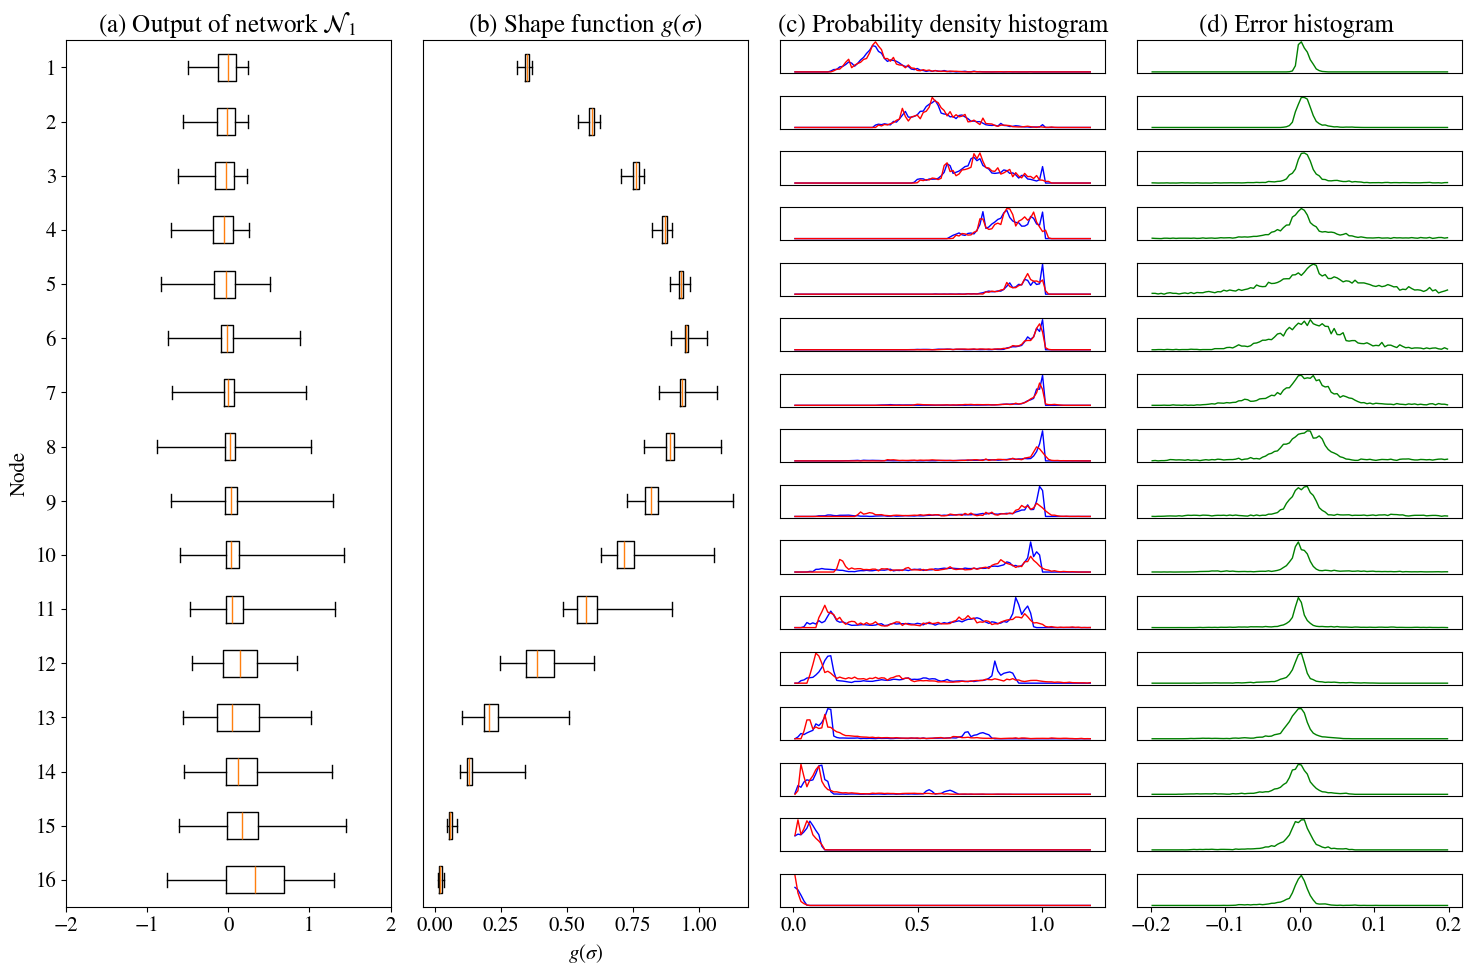

In [14]:
# Function performance_sigma_point_batched was added to visual_figure4.py and imported in section 0
performance_sigma_point_batched(model, x, valid_x, y, valid_y, k_mean, k_std)

## 2.2 SHAP Analysis

SHAP (SHapley Additive exPlanations) is an explainability technique for interpreting machine learning models. It is based on game theory and provides a way to fairly attribute the contribution of each feature to the model’s prediction. Specifically, it assigns feature importance by calculating the marginal contribution of different feature combinations to the model output.

In [15]:
# Prepare test data
X_test = valid_x.cpu().numpy()
X_test_scaled = scaler_X.transform(X_test)

As SHAP values are computed for each sample, the size of the validation dataset (~900k samples) makes it impossible to do calculations over the full dataset. Here, we first use K-means clustering to select 100 representative samples as background dataset, and then randomly select 1000 samples to calculate SHAP values and identify feature importance.

In [16]:
# Define a wrapper function to get predictions
def gp_model_predict_single_output(X, output_index):
    X_torch = torch.tensor(X, dtype=torch.float32).to(next(model.parameters()).device)
    with torch.no_grad():
        preds = likelihood(model(X_torch))  # GP prediction
    return preds.mean[:, output_index].cpu().numpy()  # Extract one output dimension

shap_values_list = []
np.random.seed(42)

for output_index in range(16):
    print(f"Computing SHAP values for output {output_index+1}/16")
    # K-means to select 100 representatives as background
    X_sample = shap.kmeans(X_test_scaled, 100)
    explainer = shap.KernelExplainer(lambda x: gp_model_predict_single_output(x, output_index), X_sample)
    
    # Randomly get 1000 samples for testing
    X_explained = shap.sample(X_test_scaled, 1000)
    shap_values = explainer.shap_values(X_explained)  
    shap_values_list.append(shap_values)

Computing SHAP values for output 1/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 2/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 3/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 4/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 5/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 6/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 7/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 8/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 9/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 10/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 11/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 12/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 13/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 14/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 15/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 16/16


  0%|          | 0/1000 [00:00<?, ?it/s]

### SHAP Summary Plots

SHAP summary plots provide insights into how different features (I0, b00, h0, ustar0) impact the model’s predictions. These plots are arranged based on following principles:  
1. Feature Importance: The features are sorted by importance, with **the most impactful feature appearing at the top**;
2. SHAP Values: The X-axis represents SHAP values, which measure the magnitude and direction of a feature’s effect on the model’s prediction (**positive SHAP values indicate that the feature increases the model's output and vice versa**);
3. Feature Values: The color gradient (blue to red) represents the feature values, which are raw input to the model (e.g., actual h0 value). **Blue = low feature values, Red = high feature values**.

From the SHAP summary plots shown below, several patterns could be observed:  
1. The SHAP values for different features generally have wide spreads, indicating the influence varies significantly across different samples.
2. **For the first 11 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00).** Low I0 values tend to decrease the prediction while high I0 values tend to increase it. As depth increases, the distribution of I0 SHAP values becomes more skewed as the contribution of high I0 values becomes more insignificant and gradually centers around 0. At the same time, low I0 values consistently show strong negative effects on model predictions.
3. **For the last 5 locations, Surface buoyancy flux (b00) becomes the most significant feature.** The influence of b00 is highly nonlinear, with low values increasing model output, middle values having negligible effects and high values decreasing model output.

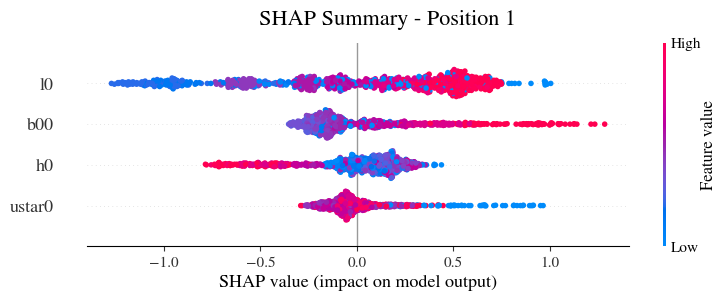

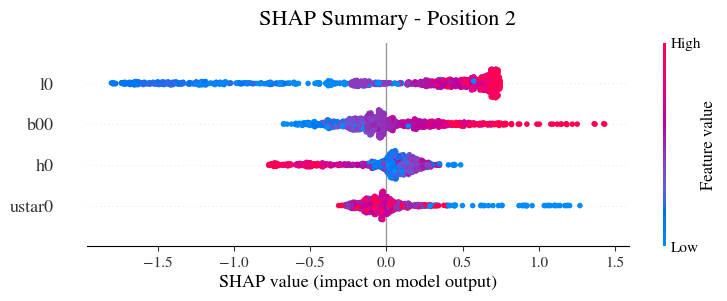

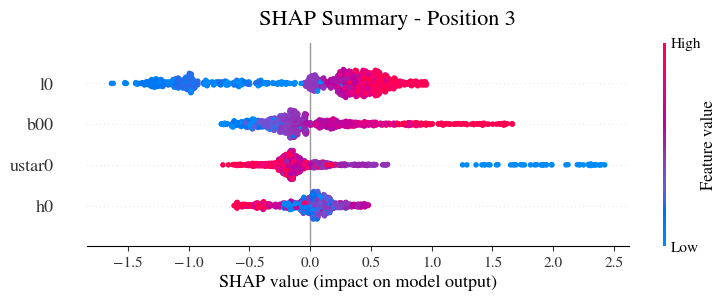

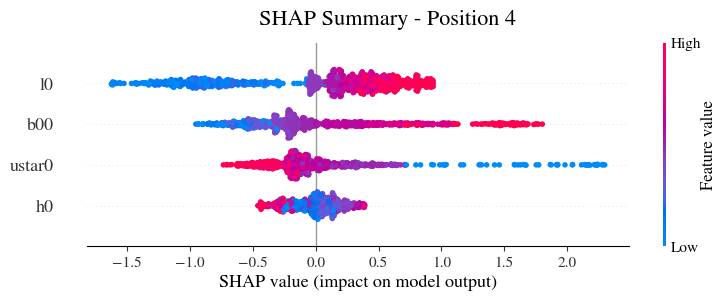

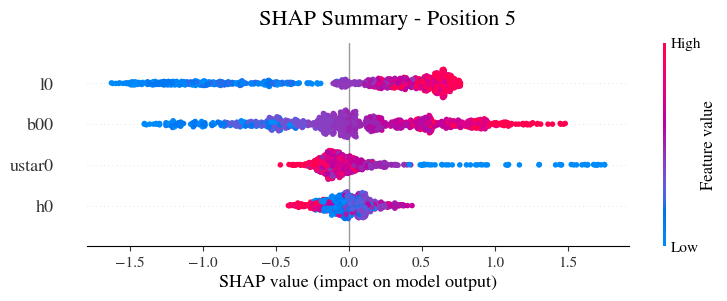

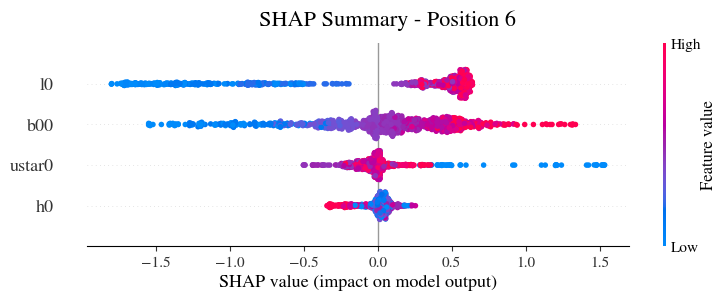

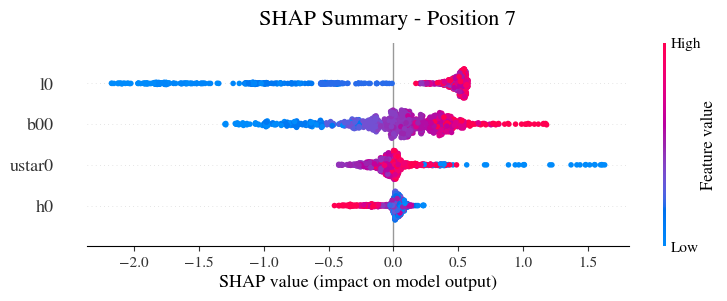

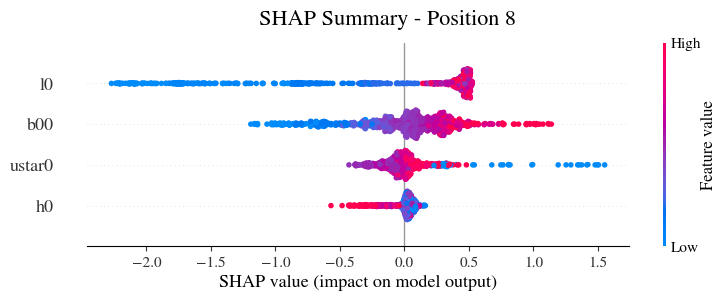

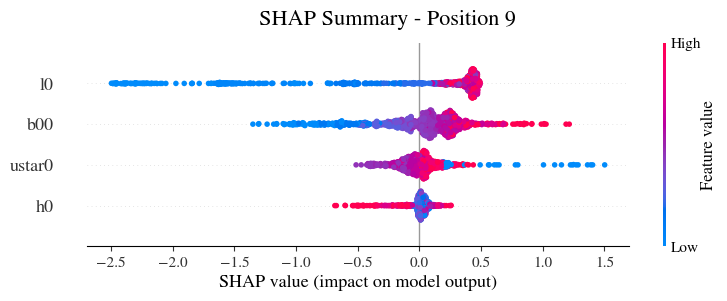

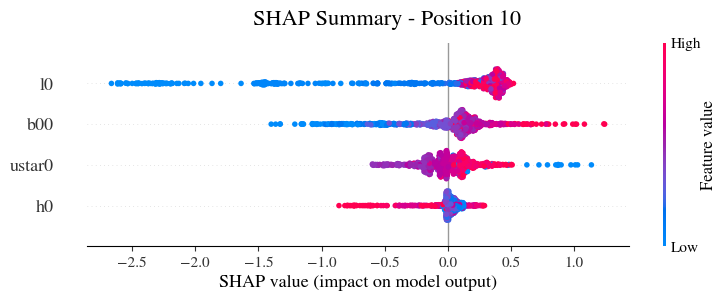

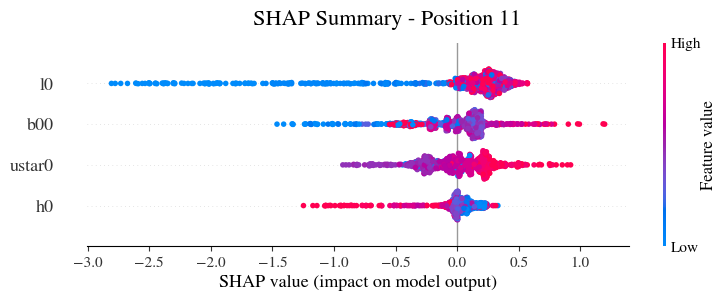

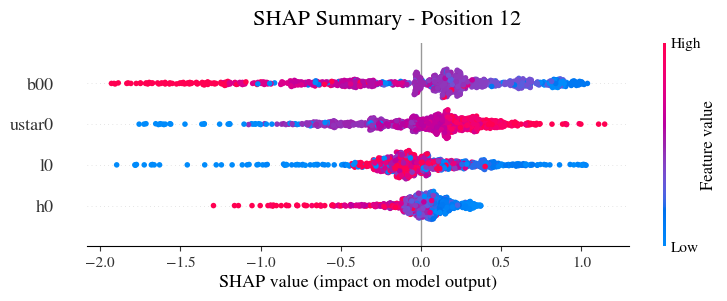

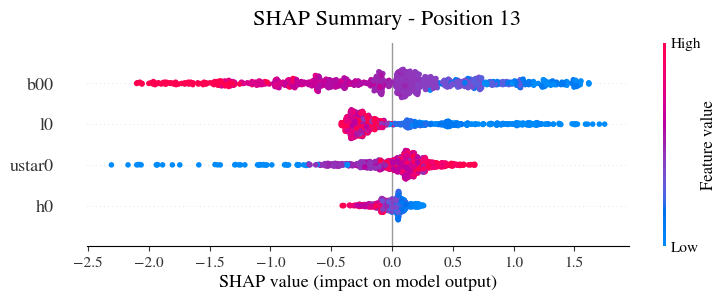

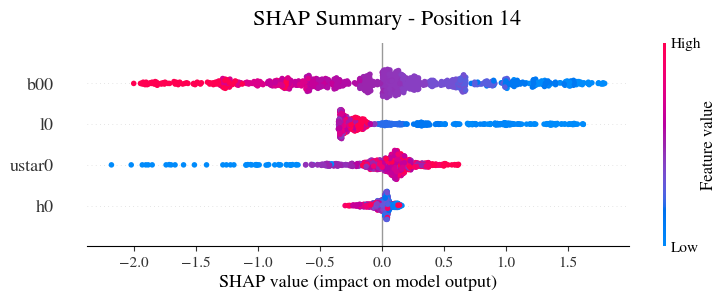

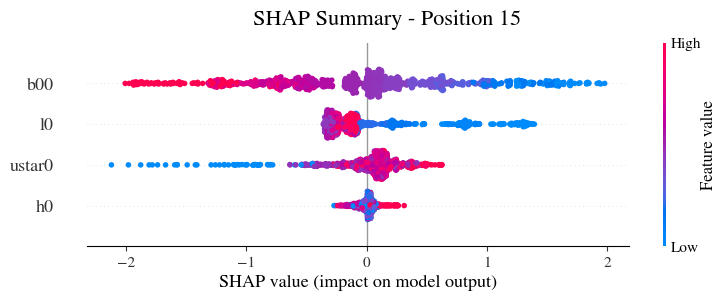

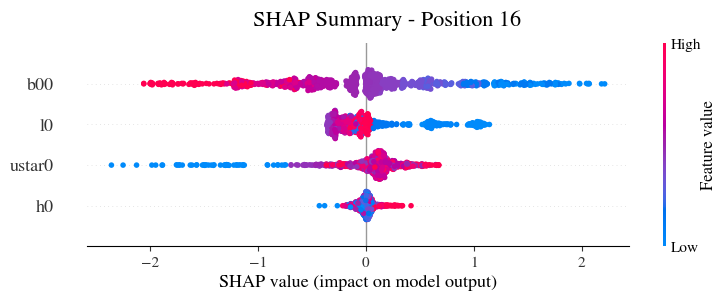

In [34]:
num_positions = 16
interval = 1
selected_indices = list(range(0, num_positions, interval))

for idx in selected_indices:
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_list[idx], X_explained, feature_names=['l0', 'b00', 'ustar0', 'h0'], show=False )
    plt.gcf().suptitle(f"SHAP Summary - Position {idx + 1}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1.1])
    plt.show()
    plt.close()

### Feature Importance Map

**The absolute values of SHAP values reflects the magnitude of influence for different features.** It can be seen from the map below that Coriolis force (I0) dominates the prediction for the upper ocean (first 11 locations) while Surface buoyancy flux (b00) plays a more important role for lower-level ocean shape function values. 

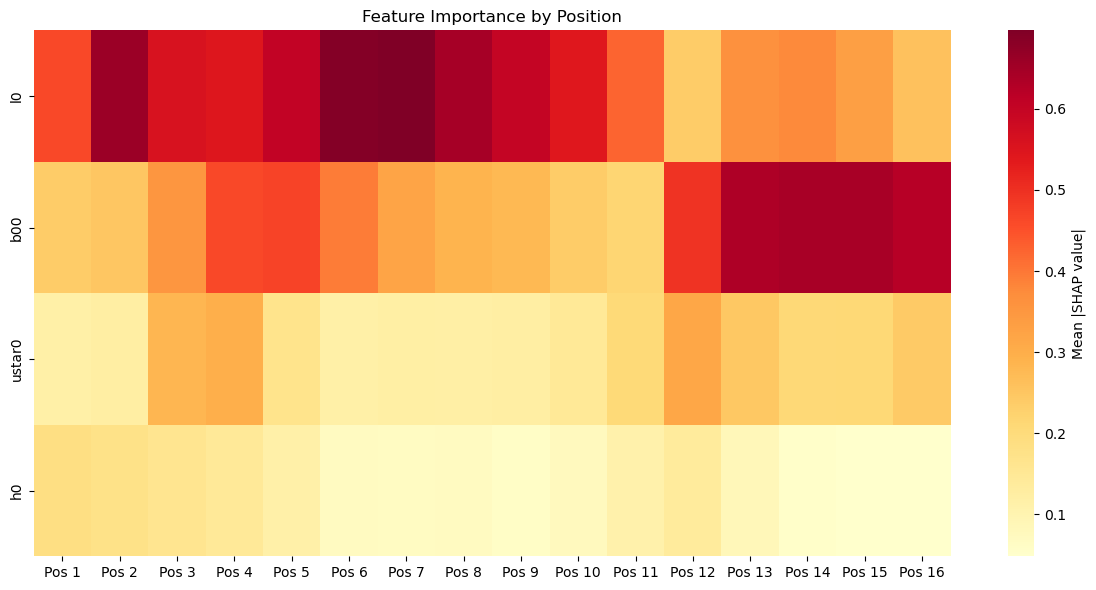

In [61]:
# Calculate average absolute SHAP value for each feature across all positions
all_importances = np.zeros((len(shap_values_list), len(feature_names)))

for i, shap_values in enumerate(shap_values_list):
    all_importances[i] = np.abs(shap_values).mean(axis=0)

# Feature Importance Heatmap
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(
    all_importances.T,  # Transpose for better visualization
    cmap="YlOrRd",
    yticklabels=feature_names,
    xticklabels=[f"Pos {i+1}" for i in range(all_importances.shape[0])],
    cbar_kws={'label': 'Mean |SHAP value|'}
)

plt.title("Feature Importance by Position")
plt.tight_layout()
plt.show()
plt.close()

### Global Feature Importance

Averaging across 16 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00). Surface friction velocity (ustar0) also impact predictions, while boundary layer depth (h0) has the least effect.

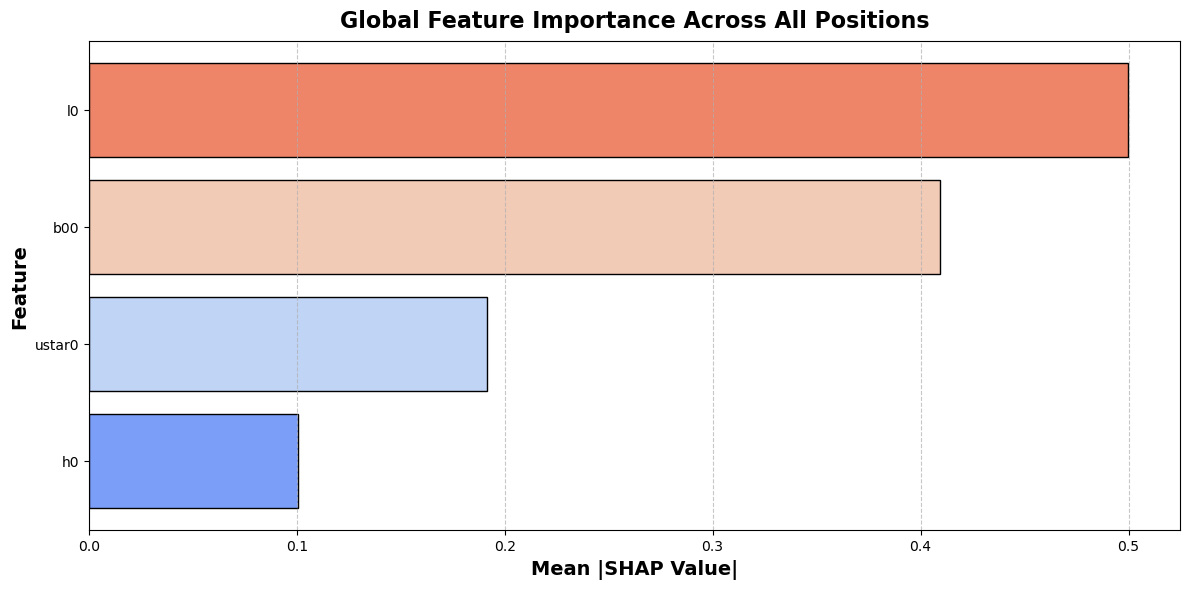

In [65]:
# Average across all positions
avg_importance = all_importances.mean(axis=0)

colors = sns.color_palette("coolwarm_r", len(avg_importance))
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_names, avg_importance, color=colors, edgecolor="black")
plt.xlabel("Mean |SHAP Value|", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("Global Feature Importance Across All Positions", fontsize=16, fontweight="bold", pad=10)
plt.gca().invert_yaxis() 
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Above results show that accounting for data interdependencies by adopting Gaussian process greatly increases shape function prediction accuracy, and adding SHAP analysis after ML models helps further identify feature interactions and importance. Such combined approach offers enhanced accuracy and explanability over pure black-box ML models.  

However, the computational complexity makes it impossible to carry out exact GP process, and SHAP values cannot be calculated for the whole dataset. In addition, SHAP results have shown large spread for different features, making it difficult to draw consistent conclusions and imposing constraints on the acquired explanability. 

# 3. Symbolic Regression